# Инструменты для работы с языком 

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [1]:
# # если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
# !wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
# !wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [4]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [6]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [7]:
from nltk import ngrams

In [8]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [9]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [10]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [11]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [12]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [13]:
list(vec.vocabulary_.items())[:10]

[('dj_kafe', 26066),
 ('тебя', 220794),
 ('то', 222115),
 ('взрослее', 112219),
 ('эта', 241509),
 ('это', 241574),
 ('пздц', 182036),
 ('нытик', 169751),
 ('ууу', 229209),
 ('сдохну', 207951)]

In [14]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [15]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.75      0.76      0.76     27641
    positive       0.77      0.76      0.77     29068

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Попробуем сделать то же самое для триграмм:

In [20]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.85      0.57      0.68     41348
    positive       0.39      0.72      0.50     15361

    accuracy                           0.61     56709
   macro avg       0.62      0.65      0.59     56709
weighted avg       0.72      0.61      0.63     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.74      0.77      0.75     26756
    positive       0.78      0.75      0.77     29953

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## PMI

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} $$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

Оценим важность биграмм в нашем обучающем корпусе.

In [26]:
import nltk
from nltk import collocations 
nltk.download('genesis')

print(type(nltk.corpus.genesis.words('english-web.txt')))
bigram_measures = collocations.BigramAssocMeasures()
# bigram_finder.apply_freq_filter(5)
bigram_finder = collocations.BigramCollocationFinder.from_documents([nltk.word_tokenize(x) for x in x_train])
bigrams = bigram_finder.nbest(bigram_measures.pmi, 100)
print(bigrams)

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\gribanov\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\genesis.zip.


<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[('+1239', '728'), ('+СОННО', '+НЕ'), ('+живіт', 'болить.ну'), ('+погода', 'крутая='), (',4', 'запирайте'), (',Дела', 'рез'), ('-/////', 'прбрм-прбрм'), ('-10,11', 'болсо'), ('-53', 'dBm'), ('-700', 'рублей.-А'), ('-АХАХАХАХ', 'ЮБКУ'), ('-АХАХАХАХХАХАХАХАХАХХА', '-АХАХАХХАХАХАХАХАХ'), ('-Айгуль', 'Маратовна'), ('-Аха', 'спетросянил'), ('-ВСЕМ', 'СПОКОЙНЫХ'), ('-Весело', 'кншн:3'), ('-Восьмигрудый', 'трипи'), ('-Время', 'эмокора'), ('-Выздоравливай', 'педрилк'), ('-Д-Д-Д-Д-Д-Д-ДРОП', 'ЗЭ'), ('-ДЕТЕЙ', 'НАКРЫЛО'), ('-ДОВАЙТИ', 'АЛДСКУЛ'), ('-Дирол', 'Сенсес'), ('-Домашка', '-кл.час'), ('-ЖАРЕНЫЙ', 'КАРТОФЕЛЬ'), ('-ЖРАТЬ', 'БАРАНКИ'), ('-ЗАШЛА', 'ОДЕЛА'), ('-Защитано', '-ес'), ('-Зелено-карие', '-Киллджой'), ('-Керем', 'севгили'), ('-Киллджой', '-Котик'), ('-Корнейчук', 'затроллила'), ('-МНОГО', 'СЛИВОК'), ('-Маладец', '-Лол'), ('-Мамаааа', 'поправь'), ('-НА', 'РЕАЛЬНЫХ'), ('-Настя', 'Пармсон'), ('-ОЗВУЧИВАТЕЛЬ', 'МУЛЬТИКОВ'), ('-ОН

Можно рассмотреть другие метрики оценки важности биграмм, например, метрику правдоподобия (подробнее про вычисление метрики можно посмотреть [здесь (пункт 5.3.4)](http://www.corpus.unam.mx/cursoenah/ManningSchutze_1999_FoundationsofStatisticalNaturalLanguageProcessing.pdf):

In [27]:
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 100)
print(bigrams)

[('(', '('), ('RT', '@'), (')', ')'), ('http', ':'), ('!', '!'), (':', 'D'), ('у', 'меня'), (':', '('), (',', 'а'), (',', 'что'), (',', 'но'), (')', 'http'), ('*', '*'), (':', ')'), ('(', ','), ('у', 'нас'), (',', '('), (':', '-'), ('не', 'могу'), (',', ')'), ('?', '?'), (')', ','), (',', ':'), ('@', '('), (',', ','), ('(', ':'), (':', ','), ('@', ')'), ('@', ','), ('&', 'lt'), ('со', 'мной'), ('@', ':'), ('(', '@'), (':', ':'), ('новый', 'год'), (';', ')'), ('gt', ';'), (')', ':'), ('не', 'знаю'), (',', '@'), (':', '*'), ('а', 'я'), ('@', '@'), (',', 'когда'), ('потому', 'что'), ('У', 'меня'), ('сих', 'пор'), ('lt', ';'), ('&', 'gt'), ('у', 'тебя'), (';', '('), ('все', 'равно'), (',', 'как'), ('с', 'тобой'), ('в', 'школу'), ('ничего', 'не'), ('&', 'amp'), ('Как', 'же'), ('Доброе', 'утро'), ('(', 'http'), (',', 'я'), (')', '@'), ('-', ')'), ('я', 'не'), ('--', '--'), (':', 'DD'), ('не', '('), ('самом', 'деле'), ('не', ')'), ('как', 'же'), ('amp', ';'), ('(', '!'), ('до', 'сих'), (',', 

Как можно заметить, немаловажную роль в текстах занимает пунктуация.

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [28]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gribanov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [30]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [32]:
from nltk.tokenize import word_tokenize

vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     29347
    positive       0.76      0.80      0.78     27362

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [33]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
tar: Error opening archive: Failed to open 'mystem-3.0-linux3.1-64bit.tar.gz'
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [34]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [ ]:
# print(mystem_analyzer.lemmatize(example))

А можно получить грамматическую информацию:

In [ ]:
# mystem_analyzer.analyze(example)

Давайте терепь используем лемматизатор майстема в качестве токенизатора.

In [37]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [58]:
# %%time

# vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
# bow = vec.fit_transform(x_train)
# clf = LogisticRegression(random_state=42)
# clf.fit(bow, y_train)
# pred = clf.predict(vec.transform(x_test))
# print(classification_report(pred, y_test))

### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [39]:
!pip install pymorphy2

In [40]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [41]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2472, 10),))]

In [42]:
ana[0].normal_form

'платить'

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [43]:
!pip install razdel

In [44]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [45]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

In [46]:
!pip install natasha

С помощью библиотеки natasha можно также лемматизировать тексты.

In [48]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    return {_.text: _.lemma for _ in doc.tokens}

In [49]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '

natasha_lemmatize(text)

{'Посол': 'посол',
 'Израиля': 'израиль',
 'на': 'на',
 'Украине': 'украина',
 'Йоэль': 'йоэль',
 'Лион': 'лион',
 'признался': 'признаться',
 ',': ',',
 'что': 'что',
 'пришел': 'прийти',
 'в': 'в',
 'шок': 'шок',
 'узнав': 'узнать',
 'о': 'о',
 'решении': 'решение',
 'властей': 'власть',
 'Львовской': 'львовский',
 'области': 'область',
 'объявить': 'объявить',
 '2019': '2019',
 'год': 'год',
 'годом': 'год',
 'лидера': 'лидер',
 'запрещенной': 'запретить',
 'России': 'россия',
 'Организации': 'организация',
 'украинских': 'украинский',
 'националистов': 'националист',
 '(': '(',
 'ОУН': 'оун',
 ')': ')',
 'Степана': 'степан',
 'Бандеры': 'бандера',
 '.': '.',
 'Свое': 'свой',
 'заявление': 'заявление',
 'он': 'он',
 'разместил': 'разместить',
 'Twitter': 'twitter',
 '«': '«',
 'Я': 'я',
 'не': 'не',
 'могу': 'мочь',
 'понять': 'понять',
 'как': 'как',
 'прославление': 'прославление',
 'тех': 'тот',
 'кто': 'кто',
 'непосредственно': 'непосредственно',
 'принимал': 'принимать',
 'уча

### mystem vs. pymorphy vs. natasha

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту, natasha тоже с этим тоже не справляется успешно:

In [50]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [51]:
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292664, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970041, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


In [52]:
print(natasha_lemmatize(homonym1))

{'За': 'за', 'время': 'время', 'обучения': 'обучение', 'я': 'я', 'прослушал': 'прослушать', 'больше': 'большой', 'сорока': 'сорок', 'курсов': 'курс', '.': '.'}


In [53]:
print(natasha_lemmatize(homonym2))

{'Сорока': 'сорок', 'своровала': 'своровать', 'блестящее': 'блестящий', 'украшение': 'украшение', 'со': 'с', 'стола': 'стол', '.': '.'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [54]:
from collections import Counter

In [55]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [56]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

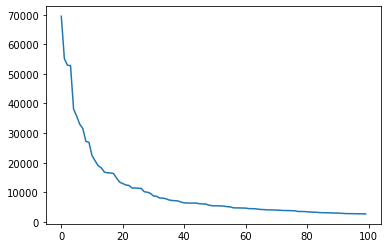

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [230]:
from nltk.corpus import stopwords
nltk.download('stopwords')
my_stopwords = stopwords.words('russian')
# noise = stopwords.words('russian') + list(punctuation)
noise = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gribanov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [231]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [232]:
df

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive
...,...,...
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative


In [233]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [234]:
def get_tokens_importance(maxdf, mindf):
    
    tfidf_vect = TfidfVectorizer(max_df=maxdf, # не берем слова что выше тресхолда
                                 min_df=mindf, # не берем что ниже тресхолда
#                                  max_features=1000, 
#                                  stop_words=noise,
                                 )
    
    bow = tfidf_vect.fit_transform(x_train)
    clf = LogisticRegression(random_state=42)
    clf.fit(bow, y_train)
    
    pred = clf.predict(tfidf_vect.transform(x_test))
    print(f'max_df= {maxdf} min_df= {mindf}')
    print(classification_report(pred, y_test))

In [235]:
# Берем все токены - f1-score получается низкая
get_tokens_importance(1, 1)

max_df= 1 min_df= 1
              precision    recall  f1-score   support

    negative       0.14      0.58      0.23      6915
    positive       0.90      0.51      0.65     49794

    accuracy                           0.52     56709
   macro avg       0.52      0.55      0.44     56709
weighted avg       0.81      0.52      0.60     56709



In [236]:
# Берем токены часто встречающиеся
get_tokens_importance(1.0, 0.285)

max_df= 1.0 min_df= 0.285
              precision    recall  f1-score   support

    negative       0.35      0.60      0.44     16283
    positive       0.77      0.55      0.64     40426

    accuracy                           0.56     56709
   macro avg       0.56      0.57      0.54     56709
weighted avg       0.65      0.56      0.58     56709



In [237]:
# Берем токены средне встречающиеся
get_tokens_importance(0.7, 0.15)

max_df= 0.7 min_df= 0.15
              precision    recall  f1-score   support

    negative       0.34      0.60      0.44     16029
    positive       0.78      0.55      0.64     40680

    accuracy                           0.56     56709
   macro avg       0.56      0.57      0.54     56709
weighted avg       0.66      0.56      0.58     56709



In [238]:
# Берем токены низкочастотные
get_tokens_importance(0.3, 1)

C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


max_df= 0.3 min_df= 1
              precision    recall  f1-score   support

    negative       0.73      0.77      0.75     26799
    positive       0.79      0.75      0.77     29910

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Судя по метрикам, низкочастотные токены наиболее важны для классификации

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [239]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     28142
    positive       1.00      1.00      1.00     28567

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [240]:
from collections import Counter

In [241]:
# corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
corpus = [token for tweet in df.text for token in word_tokenize(tweet)]
print(len(corpus))
corpus[:10]

4027088


['@', 'first_timee', 'хоть', 'я', 'и', 'школота', ',', 'но', 'поверь', ',']

In [242]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('(', 212404),
 (')', 194005),
 (',', 188295),
 (':', 177675),
 ('@', 149978),
 ('не', 69472),
 ('!', 66923),
 ('.', 57623),
 ('и', 55166),
 ('в', 52902)]

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [243]:
cool_token = '!'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.87      0.51      0.64     48399
    positive       0.17      0.58      0.26      8310

    accuracy                           0.52     56709
   macro avg       0.52      0.54      0.45     56709
weighted avg       0.77      0.52      0.59     56709



In [244]:
cool_token = ':'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.48      0.55      0.51     24715
    positive       0.61      0.54      0.57     31994

    accuracy                           0.54     56709
   macro avg       0.54      0.55      0.54     56709
weighted avg       0.55      0.54      0.55     56709



In [245]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     33113
    positive       0.83      1.00      0.91     23596

    accuracy                           0.91     56709
   macro avg       0.91      0.93      0.91     56709
weighted avg       0.93      0.91      0.91     56709



")" Это часть смайлика или сам смайлик - и его присутствие в твите в основном говорит о положительном твите и наоборот. 

## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [246]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     28094
    positive       1.00      0.99      1.00     28615

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

## Задание 3.
1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера

3) убедиться что для сетки нет переобучения

In [247]:
%%time

count_vect = CountVectorizer()
bow = count_vect.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(count_vect.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     28192
    positive       0.77      0.76      0.77     28517

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709

Wall time: 9.02 s


In [248]:
%%time

tfidf_vect = TfidfVectorizer()
bow = tfidf_vect.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(tfidf_vect.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.73      0.77      0.75     26799
    positive       0.79      0.75      0.77     29910

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709

Wall time: 9.3 s


In [249]:
from sklearn.feature_extraction.text import HashingVectorizer

In [250]:
%%time

feature_sizes = [100, 1000, 10000, 100000, 1000000]

for feature_size in feature_sizes:
    
    h_vect = HashingVectorizer(n_features=feature_size)
    h_vect.fit(x_train)

    xtrain_count =  h_vect.transform(x_train)
    xtest_count =  h_vect.transform(x_test)

    classifier = linear_model.LogisticRegression()
    classifier.fit(xtrain_count, y_train)
    predictions = classifier.predict(xtest_count)
    #predictions
    print(f'Длина hash-вектора: {feature_size}')
    print(classification_report(predictions, y_test))

Длина hash-вектора: 100
              precision    recall  f1-score   support

    negative       0.57      0.60      0.58     26814
    positive       0.62      0.59      0.61     29895

    accuracy                           0.59     56709
   macro avg       0.59      0.59      0.59     56709
weighted avg       0.60      0.59      0.59     56709

Длина hash-вектора: 1000
              precision    recall  f1-score   support

    negative       0.63      0.65      0.64     27122
    positive       0.67      0.65      0.66     29587

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.65     56709
weighted avg       0.65      0.65      0.65     56709



C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Длина hash-вектора: 10000
              precision    recall  f1-score   support

    negative       0.70      0.72      0.71     27402
    positive       0.73      0.71      0.72     29307

    accuracy                           0.71     56709
   macro avg       0.71      0.71      0.71     56709
weighted avg       0.71      0.71      0.71     56709



C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Длина hash-вектора: 100000
              precision    recall  f1-score   support

    negative       0.72      0.75      0.74     26979
    positive       0.77      0.74      0.75     29730

    accuracy                           0.74     56709
   macro avg       0.74      0.75      0.74     56709
weighted avg       0.75      0.74      0.75     56709



C:\Users\gribanov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Длина hash-вектора: 1000000
              precision    recall  f1-score   support

    negative       0.72      0.76      0.74     26788
    positive       0.78      0.74      0.76     29921

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709

Wall time: 35.9 s


In [251]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # формирует словарь как CountVect и TF-IDF 
# из унгикальных токенов и заменяет кажддый токен его айдишником 

In [252]:
# Привеедм y к 0,1

encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [253]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [254]:
train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [255]:
for raw in train_data.take(1):
    pass

In [256]:
raw

(<tf.Tensor: shape=(16,), dtype=string, numpy=
 array([b'@ksyunich98 \xd0\xb0 \xd1\x8f \xd0\xb2\xd0\xbe\xd1\x82 \xd0\xbf\xd1\x80\xd0\xb0\xd0\xba\xd1\x82\xd0\xb8\xd1\x87\xd0\xb5\xd1\x81\xd0\xba\xd0\xb8 \xd0\xbf\xd0\xbe\xd1\x81\xd1\x82\xd0\xbe\xd1\x8f\xd0\xbd\xd0\xbd\xd0\xbe \xd1\x81 \xd1\x82\xd0\xb5\xd0\xbb\xd0\xb5\xd1\x84\xd0\xbe\xd0\xbd\xd0\xb0 \xd1\x81\xd0\xb8\xd0\xb6\xd1\x83, \xd0\xbc\xd0\xb0\xd0\xbc\xd0\xb0 \xd0\xba\xd0\xbe\xd0\xbc\xd0\xbf \xd0\xb7\xd0\xb0\xd0\xbd\xd0\xb8\xd0\xbc\xd0\xb0\xd0\xb5\xd1\x82, \xd0\xb1\xd0\xbb\xd0\xb8\xd0\xbd, \xd0\xba\xd0\xb0\xd0\xba\xd0\xbe\xd0\xb3\xd0\xbe \xd1\x87\xd0\xb5\xd1\x80\xd1\x82\xd0\xb0 \xd0\xbd\xd0\xbe\xd1\x83\xd1\x82 \xd1\x81\xd0\xbb\xd0\xbe\xd0\xbc\xd0\xb0\xd0\xbb\xd1\x81\xd1\x8f?:D',
        b'\xd0\x98 \xd0\xba\xd0\xb0\xd0\xba\xd0\xbe\xd0\xb3\xd0\xbe \xd1\x84\xd0\xb8\xd0\xb3\xd0\xb0 \xd0\xbf\xd0\xbe\xd1\x81\xd0\xbb\xd0\xb5 \xd1\x82\xd0\xb0\xd0\xba\xd0\xb8\xd1\x85 \xd1\x84\xd0\xbe\xd1\x82\xd0\xbe\xd0\xba \xd0\x90\xd0\xb9\xd0\xb7\xd0\xb0 \x

In [257]:
def custom_standardization(input_data):
    
    return input_data

vocab_size = 10000 # выбрали 10000 а там было 31к
seq_len = 100 # сколько токенов в тексте -проходят по всем текстам и выбирают максимум, или берут квантильное - 
# могут быть выбросы по длинам 

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int', # что каждый токен будем переводить в индекс относительно нашего словаря vocab_size
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

embedding_dim=200 # 200-мерные вектора будут у каждого токена

In [258]:
class myNet(tf.keras.Model):
    def __init__(self):
        super(myNet, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim, name="embedding")
        self.conv1 = Conv1D(200, (3))
        self.conv2 = Conv1D(200, (3))
        self.gPool = GlobalAveragePooling1D()
        self.fc1 = Dense(100, activation='relu')
        self.fc2 = Dense(1)


    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        x1 = self.conv1(x)
        x = self.conv2(x)
        x = self.gPool((x + x1)/2)
        x = self.fc1(x)
#         x = self.ss(x)
        return self.fc2(x)
    
# тут подход что все выделено в класс - ти удобнее писать в таком подходе!!!!
# так как еслп будут повторться слои 

In [259]:
mmodel = myNet()

In [260]:
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [261]:
mmodel.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
10633/10633 [==============================] - 184s 17ms/step - loss: 0.4023 - accuracy: 0.7662 - val_loss: 0.3562 - val_accuracy: 0.7959
Epoch 2/5
10633/10633 [==============================] - 183s 17ms/step - loss: 0.3411 - accuracy: 0.8086 - val_loss: 0.3547 - val_accuracy: 0.7961
Epoch 3/5
10633/10633 [==============================] - 188s 18ms/step - loss: 0.3203 - accuracy: 0.8217 - val_loss: 0.3616 - val_accuracy: 0.7999
Epoch 4/5
10633/10633 [==============================] - 188s 18ms/step - loss: 0.3019 - accuracy: 0.8343 - val_loss: 0.3771 - val_accuracy: 0.7932
Epoch 5/5
10633/10633 [==============================] - 181s 17ms/step - loss: 0.2818 - accuracy: 0.8480 - val_loss: 0.3939 - val_accuracy: 0.7904


Переобучение уже пошло с 3-й эпохи - и дальше стало только усиливаться

In [294]:
preds = mmodel.predict(valid_data)

In [295]:
preds

array([[-7.6599103e-01],
       [ 1.6081847e-02],
       [ 1.0182415e+01],
       ...,
       [-3.7103333e+01],
       [ 1.4859509e+00],
       [ 2.7088312e+01]], dtype=float32)

In [296]:
# Приведем preds в бинарный вид
preds = [int(i[0]>0) for i in preds]

In [292]:
# pred = clf.predict(tfidf_vect.transform(x_test))
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     28567
           1       0.80      0.82      0.81     28142

    accuracy                           0.81     56709
   macro avg       0.81      0.81      0.81     56709
weighted avg       0.81      0.81      0.81     56709

